In [1]:
import pandas as pd 
import gensim
from gensim import corpora, models
from gensim.models import Phrases
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldaseqmodel import LdaSeqModel
from tqdm import tqdm
import matplotlib.pyplot as plt

# Preparation

## Texts List

In [2]:
text_list=[]
def create_token(tweet) :
  tweet=tweet.split()
  text_list.append(tweet)

In [3]:
raw_data=pd.read_csv('src\cleaned_mb.csv')

In [5]:
raw_data['full_text'] = raw_data['full_text'].astype(str)
raw_data['full_text'].apply(create_token)

In [7]:
text_list[0]

['kerja', 'ajar', 'senang', 'senang', 'penuh', 'semangat', 'merdeka']

## Bigram and Trigram

In [8]:
bigram = Phrases(text_list, min_count=10)
trigram = Phrases(bigram[text_list])

In [9]:
for idx in range(len(text_list)):
    for token in bigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)
    for token in trigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)

## Dictionary

In [10]:
dictionary = corpora.Dictionary(text_list)
dictionary.filter_extremes(no_below=5, no_above=0.2)

In [11]:
print(dictionary)

Dictionary<8709 unique tokens: ['kerja', 'penuh', 'semangat', 'senang', 'depan']...>


In [12]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]

## Corpus dg TF-IDF

In [13]:
tfidf = models.TfidfModel(doc_term_matrix) #build TF-IDF model
corpus_tfidf = tfidf[doc_term_matrix]

In [14]:
for i in corpus_tfidf :
    print(i)
    break

[(0, 0.3057356714255539), (1, 0.42700010166837093), (2, 0.2522360723550572), (3, 0.8127567755460801)]


## Time Slice 

In [15]:
raw_data['created_at'] = pd.to_datetime(raw_data['created_at'])

In [16]:
# pick the data with year 2019
num_19 = len(raw_data[raw_data['created_at'].dt.year == 2019])

def slice_num_data(year):
    num = []
    num.append(len(raw_data.loc[(raw_data['created_at'].dt.year == year) & (raw_data['created_at'].dt.month < 4)]))
    num.append(len(raw_data.loc[(raw_data['created_at'].dt.year == year) & (raw_data['created_at'].dt.month > 3) & (raw_data['created_at'].dt.month < 7)]))
    num.append(len(raw_data.loc[(raw_data['created_at'].dt.year == year) & (raw_data['created_at'].dt.month > 6) & (raw_data['created_at'].dt.month < 10)]))
    num.append(len(raw_data.loc[(raw_data['created_at'].dt.year == year) & (raw_data['created_at'].dt.month > 9)]))
    return num

In [17]:
# make splitted data for 2019 - 2024
num_20 = slice_num_data(2020)
num_21 = slice_num_data(2021)
num_22 = slice_num_data(2022)
num_23 = slice_num_data(2023)
num_24 = slice_num_data(2024)
# make a list of data
num_data = [num_19]
num_data = num_data + num_20 + num_21 + num_22 + num_23 + num_24
num_data.remove(0)
num_data.remove(0)
print(num_data)

[1395, 1597, 1419, 3588, 2078, 1183, 2854, 1387, 1590, 1111, 1004, 2855, 2564, 1751, 2258, 1664, 2477, 1548, 275]


# LDA

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step), desc="Topics Progress"): #range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=100, passes=10, workers=15) 
        # model = LdaSeqModel(corpus=corpus,
        #                          id2word=dictionary,
        #                          time_slice=num_data,
        #                          num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
start=1
limit=50
step=1
model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus_tfidf,
                                                        texts=text_list, start=start, limit=limit, step=step)

Topics Progress: 100%|██████████| 49/49 [32:22<00:00, 39.65s/it]


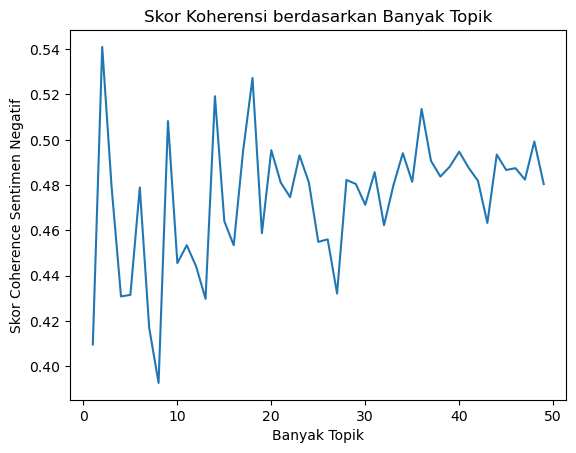

In [ ]:
x = range(start, limit, step)

plt.figure()
plt.plot(x, coherence_values)
plt.title('Skor Koherensi berdasarkan Banyak Topik')
plt.xlabel("Banyak Topik")
plt.ylabel("Skor Coherence")
# plt.savefig('lda-cores15-91K-50.jpg')
plt.show()

In [ ]:
temp=0
index=0
for i in range(49):
    if coherence_values[i]>temp:
        temp=coherence_values[i]
        index=i+1
print(f'Koherensi tertinggi dicapai pada {index} topik dengan nilai {temp}')

Koherensi tertinggi dicapai pada 2 topik dengan nilai 0.540999081137034


In [ ]:
model_list[33].save('lda_91K_15c.model')

In [ ]:
for idx, topic in model_list[33].print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.025*"kasus_positif" + 0.010*"thailand" + 0.009*"taman" + 0.007*"traveling" + 0.006*"per_hari" + 0.006*"keluar_rumah" + 0.006*"longsor" + 0.005*"hutan" + 0.005*"masa_psbb" + 0.005*"kasus"
Topic: 1 Word: 0.026*"wabah_corona" + 0.025*"imbas_corona" + 0.011*"corona" + 0.010*"tembus_rp" + 0.009*"wabah" + 0.008*"imbas" + 0.008*"orang_kaya" + 0.007*"virus_corona" + 0.007*"bicara_soal" + 0.007*"pariwisata"
Topic: 2 Word: 0.015*"anggota_dpr" + 0.013*"hand_sanitizer" + 0.010*"anggota_dprd" + 0.008*"anggota" + 0.008*"pemkot" + 0.008*"tingkat_mati" + 0.007*"meghan_markle" + 0.007*"karen_pooroe" + 0.007*"pangeran_harry" + 0.006*"jalan_rapid"
Topic: 3 Word: 0.016*"tengah_wabah" + 0.009*"walkot" + 0.008*"jakbar" + 0.007*"banjir" + 0.007*"tangerang" + 0.006*"korupsi" + 0.006*"kapolda" + 0.006*"seluruh" + 0.006*"banjir_jakarta" + 0.005*"duga_korupsi"
Topic: 4 Word: 0.073*"virus_corona" + 0.034*"new_normal" + 0.024*"virus" + 0.015*"corona" + 0.014*"minta_maaf" + 0.011*"normal" + 0.011*"

# DLDA

In [ ]:
# model = LdaSeqModel.load('dlda_mb')

In [31]:
model = LdaSeqModel(corpus=corpus_tfidf,
                                 id2word=dictionary,
                                 time_slice=num_data,
                                 num_topics=9)

c:\ProgramData\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\ProgramData\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)
c:\ProgramData\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\ProgramData\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\ProgramData\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total)

In [33]:
# model.save('dlda_mb.model')

# Coherence Score

In [42]:
coh_c_v = [CoherenceModel(topics=model.dtm_coherence(time=i), corpus=corpus_tfidf, 
                dictionary=dictionary, texts = text_list, coherence='c_v').get_coherence() 
 for i in range(len(num_data))]

coh_u_mass = [CoherenceModel(topics=model.dtm_coherence(time=i), corpus=corpus_tfidf, 
                dictionary=dictionary, coherence='u_mass').get_coherence() 
 for i in range(len(num_data))]

coh_score_mb_9 = [coh_c_v, coh_u_mass]

In [52]:
coh_score = pd.DataFrame({'U_Mass Score': coh_u_mass, 'C_V Score': coh_c_v})
coh_score.head()

,U_Mass Score,C_V Score
0,-6.513186,0.497137
1,-6.559677,0.492403
2,-6.563711,0.491991
3,-6.475133,0.489592
4,-6.599052,0.488412


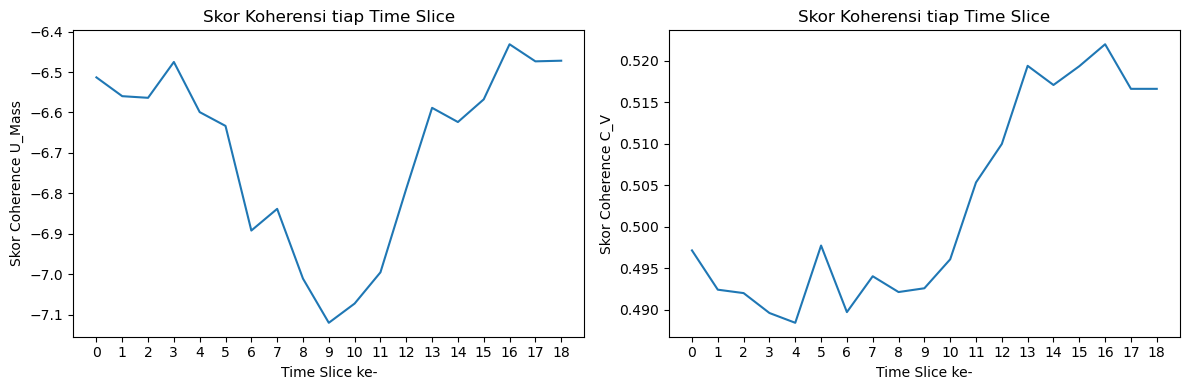

In [66]:
x = range(0, len(coh_score))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(x, coh_score['U_Mass Score'])
plt.title('Skor Koherensi tiap Time Slice')
plt.xlabel("Time Slice ke-")
plt.ylabel("Skor Coherence U_Mass")
plt.xticks(x)

plt.subplot(1,2,2)
plt.plot(x, coh_score['C_V Score'])
plt.title('Skor Koherensi tiap Time Slice')
plt.xlabel("Time Slice ke-")
plt.ylabel("Skor Coherence C_V")
plt.xticks(x)

plt.tight_layout()
plt.show()

In [51]:
coh_score.to_csv('coh_score_mb_9.csv')